# Alternative Approach

In [46]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import gensim
import nltk
import pickle
import multiprocessing
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer

# Text data processing

In [2]:
df = pd.read_pickle("../data/cleaned_df")
df.head()

,question,cleaned,length,wc
0,Are you there?,are you there,13,3
1,Firstname:,firstname,9,1
2,I get irritated easily.,i get irritated easily,22,4
3,Comments,comments,8,1
4,Let's do a survey about exercising?,lets do a survey about exercising,33,6


In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
# words from the wordcloud
stop_words.extend(['thank', 'please', 'whats', 'thanks', 'email', 'would', 'us', 'will', 'address', 
                   'question', 'questions', 'many', 'must', 'could', 'should'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARosa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def stemming(docs):
    porter_stemmer=nltk.PorterStemmer()
    return [[porter_stemmer.stem(word) for word in doc] for doc in docs]

# simple_preprocess: it lowercases, tokenizes, de-accents (optional) with deacc
def extract_words(questions):
    for q in questions:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(q), deacc=True))
        
def remove_stopwords(docs):
    # docs is a list of document. A document being a list of words
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in docs]

In [5]:
data = df.cleaned.values.tolist()
data[:10]

['are you there',
 'firstname',
 'i get irritated easily',
 'comments',
 'lets do a survey about exercising',
 'do you like our design',
 'thank you you are part of us now we will contact you with surprises soon',
 'have you ever paid for a service like this before',
 'what type of services are you interested in',
 'would you recommend indivirtual to other clients']

In [6]:
corpus = list(extract_words(data))
corpus[:10]

[['are', 'you', 'there'],
 ['firstname'],
 ['get', 'irritated', 'easily'],
 ['comments'],
 ['lets', 'do', 'survey', 'about', 'exercising'],
 ['do', 'you', 'like', 'our', 'design'],
 ['thank',
  'you',
  'you',
  'are',
  'part',
  'of',
  'us',
  'now',
  'we',
  'will',
  'contact',
  'you',
  'with',
  'surprises',
  'soon'],
 ['have', 'you', 'ever', 'paid', 'for', 'service', 'like', 'this', 'before'],
 ['what', 'type', 'of', 'services', 'are', 'you', 'interested', 'in'],
 ['would', 'you', 'recommend', 'indivirtual', 'to', 'other', 'clients']]

In [7]:
corpus_sw = remove_stopwords(corpus)
len(corpus_sw)

4306

In [8]:
def remove_empty_list(docs):
    return [doc for doc in docs if len(doc)>0]   

In [9]:
final_corpus = remove_empty_list(corpus_sw)

In [10]:
final_corpus_stem = stemming(final_corpus)
final_corpus_stem[:10]

[['firstnam'],
 ['get', 'irrit', 'easili'],
 ['comment'],
 ['let', 'survey', 'exercis'],
 ['like', 'design'],
 ['part', 'contact', 'surpris', 'soon'],
 ['ever', 'paid', 'servic', 'like'],
 ['type', 'servic', 'interest'],
 ['recommend', 'indivirtu', 'client'],
 ['select', 'bunch', 'stuff']]

In [ ]:
# TODO save the corpus as a pickle

# Doc2Vec

https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

To train the model, we’ll need to associate a tag/number with each document of the training corpus. In our case, the tag is simply the zero-based line number.

In [11]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_corpus_stem)]

In [12]:
print(documents[:2])

[TaggedDocument(words=['firstnam'], tags=[0]), TaggedDocument(words=['get', 'irrit', 'easili'], tags=[1])]


In [13]:
cores = multiprocessing.cpu_count()
print(cores)

4


In [14]:
d2v_model = Doc2Vec(vector_size=50, min_count=1, workers=cores-1)
d2v_model.build_vocab(documents)
# Count of sentences
total_samples = d2v_model.corpus_count
total_samples

4006

In [15]:
start = time()

d2v_model.train(documents, total_examples=total_samples, epochs=30, report_delay=1)

end = time()
result = end - start
print('Time to train the model: = %.3f seconds' % result)


Time to train the model: = 5.761 seconds


In [16]:
# unique word count in the vocabulary
# wv contains the mapping between words and embeddings. 
print(len(list(d2v_model.wv.vocab)))

2173


In [20]:
# dv contains the paragraph vectors learned from the training data. Workaround to get the vectors since there is 
# a bug with dv
# printing the vector embeddings for the first document
print(d2v_model.__dict__['docvecs'][0])

[ 0.01828095 -0.01161459 -0.03549461 -0.06302511  0.0086281  -0.07857449
 -0.05345789 -0.01069882  0.01415775 -0.03169349 -0.02846215  0.03012632
  0.01128201  0.00479274  0.09456352  0.04035947 -0.03215443 -0.14354128
  0.02728761  0.00904494  0.06605706 -0.02980579 -0.02048273  0.02531907
  0.0706407  -0.00330988 -0.06455009 -0.00716657 -0.02954319  0.01365033
 -0.00783302 -0.03612248 -0.00129961  0.00241372 -0.02085019 -0.01207652
 -0.04227084  0.08551898 -0.03647259  0.03294102 -0.00668255  0.06695747
  0.11367755 -0.02108269 -0.02298834 -0.0626253   0.00528375  0.0451779
 -0.01660063 -0.0369475 ]


In [21]:
len(d2v_model.__dict__['docvecs'])

4006

Now we have model with the document vector embeddings. 

In [33]:
# vector embeddings data
vectors_map = d2v_model.__dict__['docvecs']

In [34]:
vectors_map[0]

array([ 0.01828095, -0.01161459, -0.03549461, -0.06302511,  0.0086281 ,
       -0.07857449, -0.05345789, -0.01069882,  0.01415775, -0.03169349,
       -0.02846215,  0.03012632,  0.01128201,  0.00479274,  0.09456352,
        0.04035947, -0.03215443, -0.14354128,  0.02728761,  0.00904494,
        0.06605706, -0.02980579, -0.02048273,  0.02531907,  0.0706407 ,
       -0.00330988, -0.06455009, -0.00716657, -0.02954319,  0.01365033,
       -0.00783302, -0.03612248, -0.00129961,  0.00241372, -0.02085019,
       -0.01207652, -0.04227084,  0.08551898, -0.03647259,  0.03294102,
       -0.00668255,  0.06695747,  0.11367755, -0.02108269, -0.02298834,
       -0.0626253 ,  0.00528375,  0.0451779 , -0.01660063, -0.0369475 ],
      dtype=float32)

In [35]:
type(vectors_map)

gensim.models.keyedvectors.Doc2VecKeyedVectors

In [36]:
data = []
for i in range(len(vectors_map)):
    data.append(vectors_map[i])

# Clustering with KMeansClusterer

In [37]:
start = time()
NUM_CLUSTERS=7 # based on the optimal number of topics of a previous approach on this data
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
end = time()
result = end - start
print('KMeans Training time = %.3f seconds' % result)

print(len(assigned_clusters))

KMeans Training time = 208.955 seconds
4006


In [38]:
# clusters for the first 10 entries in the data
assigned_clusters[:10]

[1, 0, 0, 1, 0, 0, 1, 3, 0, 0]

In [39]:
# list the first ten documents in the corpus
final_corpus_stem[:10]

[['firstnam'],
 ['get', 'irrit', 'easili'],
 ['comment'],
 ['let', 'survey', 'exercis'],
 ['like', 'design'],
 ['part', 'contact', 'surpris', 'soon'],
 ['ever', 'paid', 'servic', 'like'],
 ['type', 'servic', 'interest'],
 ['recommend', 'indivirtu', 'client'],
 ['select', 'bunch', 'stuff']]

# Clustering with KMeans

In [40]:
start = time()
kmeans = KMeans(n_jobs=-1, n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans.fit(data)
end = time()
result = end - start
print('KMeans Training time = %.3f seconds' % result)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans Training time = 0.532 seconds


In [41]:
len(labels)

4006

In [42]:
# clusters for the first 10 entries in the data
labels[:10]

array([3, 5, 0, 2, 3, 2, 0, 4, 2, 5])

In [43]:
# list the first ten documents in the corpus
final_corpus_stem[:10]

[['firstnam'],
 ['get', 'irrit', 'easili'],
 ['comment'],
 ['let', 'survey', 'exercis'],
 ['like', 'design'],
 ['part', 'contact', 'surpris', 'soon'],
 ['ever', 'paid', 'servic', 'like'],
 ['type', 'servic', 'interest'],
 ['recommend', 'indivirtu', 'client'],
 ['select', 'bunch', 'stuff']]

# Find optimal number of clusters

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.  **Inertia** is calculated as the sum of squared distance for each point to it's closest centroid, i.e., its assigned cluster. So $I=∑_i(d(i,cr))$ where cr is the centroid of the assigned cluster and d is the squared distance.

Let´s explore up to 15 clusters to check if we find an optimal value. We use "k-means++" instead of "random" to ensure centroids are initialized with some distance between them. In most cases, this will be an improvement over "random". 

In [44]:
def km_check(data, no_clusters=15, k_means_method='k-means++'):
    """runs k-means clustering over no_clusters to get an idea of # clusters required for data.
    returns a plot with clusters v SSE. """
    sse = []
    for cluster in range(1, no_clusters):
        kmeans = KMeans(n_jobs=-1,
                        n_clusters=cluster,
                        init=k_means_method,
                        random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    analysis = pd.DataFrame({'Cluster': range(1, no_clusters), 'SSE': sse})
    plt.figure(figsize=(12, 6))
    plt.plot(analysis['Cluster'], analysis['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia/SSE')
    plt.show()

C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kme

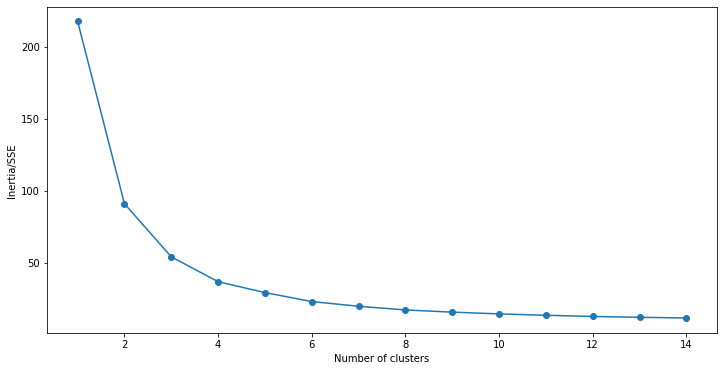

Training time = 8.654 seconds


In [47]:
start = time()
km_check(data)
end = time()
result = end - start
print('Training time = %.3f seconds' % result)

The ideal number of clusters seems to be 4 or 5, so according to this space representation of the documents we need less clusters than the number of topics found with the LDA technique.

In [48]:
final_model = KMeans(n_jobs=-1, n_clusters=4, init='k-means++', random_state=42)
final_model.fit(data)

C:\Users\ARosa\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=4, n_jobs=-1, random_state=42)

In [49]:
labels = final_model.labels_
centroids = final_model.cluster_centers_

## Cluster distribution of documents

Text(0, 0.5, 'Volume of docs')

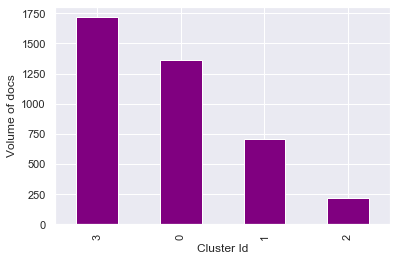

In [58]:
import seaborn as sns
sns.set(style="darkgrid", palette="viridis")
labels_df = pd.DataFrame(labels, columns =['cluster_id'])
labels_df.cluster_id.value_counts().plot.bar(color='purple')
plt.xlabel('Cluster Id')
plt.ylabel('Volume of docs')

The cluster with the highest number of assigned documents is cluster 3 and the smallest cluster is the one with id 2.

In [61]:
doc_labels = pd.DataFrame(columns=['tokens', 'cluster_id'])
doc_labels.tokens = final_corpus_stem
doc_labels.cluster_id = labels
doc_labels.head()

,tokens,cluster_id
0,[firstnam],3
1,"[get, irrit, easili]",1
2,[comment],0
3,"[let, survey, exercis]",3
4,"[like, design]",3


In [64]:
doc_labels.loc[doc_labels.cluster_id == 3, "tokens"].head(15)

0                                           [firstnam]
3                               [let, survey, exercis]
4                                       [like, design]
5                       [part, contact, surpris, soon]
12                                                [ok]
13                                     [favorit, beer]
14                                        [legal, bit]
15                                 [much, like, pizza]
16                                              [titl]
18    [welcom, test, form, itll, take, minut, complet]
24                                      [happi, today]
29                               [favourit, run, song]
30                         [provid, telephon, connect]
34                        [like, creat, form, htmlphp]
36                                          [feedback]
Name: tokens, dtype: object

In [66]:
doc_labels.loc[doc_labels.cluster_id == 1, "tokens"].head(15)

1                                  [get, irrit, easili]
8                        [recommend, indivirtu, client]
9                                [select, bunch, stuff]
11                                [els, thrown, ground]
19                                [get, stress, easili]
27         [feel, virtual, topic, highli, interest, go]
44                           [import, senior, portrait]
49                   [strongdo, ux, design, teamstrong]
67                  [count, game, quantiti, dog, choos]
69    [like, mention, member, team, stood, provid, e...
70                                      [top, prioriti]
72                                       [monkey, rule]
78                                     [salari, requir]
79    [signific, discount, avail, booth, make, like,...
92                                   [particip, genuin]
Name: tokens, dtype: object

OTHER APPROACH

Use a pretrained model with embeddings and train it with our vocabulary. Thus we can get a bigger corpus incorporating more words and add more relations. Are the clusters done with this approach more meaningful but maybe we are adding also more noise?
https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights

In [ ]:
# it loads only the map with words and vectors of the trained model, instead of the whole model
model = KeyedVectors.load_word2vec_format("glove.6B.50d.txt", binary=False)
# add your vocabulary
model_2.build_vocab([list(your_model.vocab.keys())], update=True)
model_2.intersect_word2vec_format("glove.6B.50d.txt", binary=False, lockf=1.0)
model_2.train(sentences, total_examples=total_examples, epochs=model_2.iter)

# References

https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

https://ai.intelligentonlinetools.com/ml/text-clustering-word-embedding-machine-learning/

https://cs.stanford.edu/~quocle/paragraph_vector.pdf

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights